# Stereographic Visualization of 5-Dimensional Regular Polytopes
(https://www.mdpi.com/2073-8994/11/3/391#FD7-symmetry-11-00391)

In [34]:
# imports
import numpy as np
import matplotlib.pyplot as plt

## Implementation of the Fundemental Region Algorithm (FRA) according to Wang et al.

In [100]:
# https://www.mdpi.com/2073-8994/11/3/391#FD7-symmetry-11-00391

def fundamental_region_algorithm(x_0, v_k):
    '''
    Implementation of the Fundemental Region Algorithm for stereographic projection (Want et al., 2019).

            Parameters:
                    x_0 (list): input vector
                    v_k (list): list of the normal vectors of the fundamental region.

            Returns:
                    x_n: reflected point, that is element of the fundamental region
                    n: reflection number
    '''
    # # define reflection number n and sign
    # n = 0
    # sign = 0
    # # list of points and reflections 
    # list_of_points = [x_0]

    # # compute sign for relation between x_0 and v_k
    # for v_k in fundamental_root_system:
    #     if np.dot(x_0,v_k) > 0 :
    #         sign += 1
    
    # while sign < 5:
    #     n += 1
    #     for v_k in fundamental_root_system:
    #         if np.dot(list_of_points[n-1], v_k) < 0:
    #             # stereographic projection
    #             x_n = (np.array(list_of_points[n-1]) - 2 * np.dot(list_of_points[n-1], v_k) / np.dot(v_k, v_k) * np.array(v_k)).tolist()
            
    #         # compute sign for relation between x_n and v_i
    #         sign = 0
    #         for v_i in fundamental_root_system:
    #             if np.dot(x_n, v_i) > 0:
    #                 sign += 1
            
    #         # break while loop (but why?)
    #         list_of_points.append(x_n)
    #         break

    n = 1
    # x = np.array([x_0])
    x_n = x_0
    while True:
        for k in range(5):
            if np.dot(x_n,v_k[k]) < 0:
                x_n = x_n - 2 * (np.dot(x_n,v_k[k]) / np.dot(v_k[k],v_k[k])) * v_k[k]
                # x = np.append(x,np.array([x_n]), axis=0)
                break

        if all(np.dot(x_n,v_k[k]) >= 0 for k in range(4)):
            break

        n += 1

    return x_n, n

In [ ]:
# inverse stereographic projection from 3D to 5D

def get_theta_three_squared(vector_3d, radius_3):
    return radius_3**2 * np.dot(vector_3d, vector_3d)

def get_theta_four_squared(vector_3d,radius_4, theta3_squared):
    return (radius_4 / theta3_squared + 1)**2 * (4*theta3_squared + (theta3_squared - 1)**2)

def inv_stereo_projection(vector_3d, radius_3, radius_4, theta3_squared, theta4_squared):
    factor = 1 / (theta4_squared + 1) * radius_3 * radius_4 / (theta3_squared + 1)
    vector_5d = np.zeros(5)
    vector_5d[:3] = 4 * vector_3d
    x4 = 2 * (theta3_squared - 1) / radius_3
    x5 = (theta3_squared + 1) * (theta4_squared - 1) / (radius_3*radius_4)
    vector_5d[3:] = np.array([x4, x5])
    return factor * vector_5d



In [97]:
# fundamental region algorithm according to Quyang et al.
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8047461

def fra_quyang(x_0, v_k):
    n = 1
    x = np.array([x_0])
    while True:
        for k in range(4):
            if np.dot(x[n-1],v_k[k]) < 0:
                x_n = x[n-1] - 2 * (np.dot(x[n-1],v_k[k]) / np.dot(v_k[k],v_k[k])) * v_k[k]
                x = np.append(x,np.array([x_n]), axis=0)
                break

        if all(np.dot(x_n,v_k[k]) >= 0 for k in range(4)):
            break

        n += 1

    return x, n

def fra_quyang_vectorized(x_0, v_k):
    x = np.array([x_0])
    while True:
        dot_products = np.dot(x[-1], v_k)
        negative_mask = dot_products < 0

        if not np.any(negative_mask):
            break

        x_n = x[-1] - 2 * (dot_products[negative_mask] / np.dot(v_k[negative_mask].T, v_k[negative_mask]))[:, None] * v_k[negative_mask]
        x = np.concatenate((x, x_n), axis=0)

    return x, x.shape[0]

# inverse stereographic projection from N-D to (N+1)-D
def inv_stereo_projection(x_nd):
    '''
    Implementation of the inverse stereographic projection (Want et al., 2019).

            Parameters:
                    x_nd (array): Inital vector with dimension d and arbitrary number of samples. Shape should be [d,samples]
            
            Returns:
                    x_nd+1 (array): Outpot vector with dimension d + 1 and shape: [d+1,samples]
    '''
    # calculate factor for scaling
    factor = 1 / (np.sum(x_nd**2, axis=0) + 1)
    # create array of higher dimension with same amount of samples 
    x_n1d = np.zeros([x_nd.shape[0]+1, x_nd.shape[1]])
    x_n1d[:x_nd.shape[0]] = 2 * x_nd
    x_n1d[x_nd.shape[0]:] = np.sum(x_nd**2, axis=0) - 1
    x_n1d = np.divide(x_n1d, factor)

    return x_n1d

## Functions for visualisation

In [102]:
# create points in 2-D area inside of circle with certain radius R
def create_2d_points_inside_circle(R=4, steps = 1000):
    radius = np.arange(0,R,R/steps)
    theta = np.linspace(0,2*np.pi,steps)
    x_2d = np.zeros([2,radius.size*theta.size])
    for ind, r in enumerate(radius):
        x_2d[:,ind*steps:(ind+1)*steps] = r * np.array([np.cos(theta),np.sin(theta)])
    return x_2d

# plot points in 2-D
def plot_2d(x_2d, fra_array=None):
    x = x_2d[0]
    y = x_2d[1]
    if fra_array is not None:
        is_odd = fra_array % 2 == 1
        colors = np.where(is_odd, "tab:green", "tab:red")
        plt.scatter(x, y, c=colors, marker='.')
    else:
        plt.scatter(x, y, marker='.')
    plt.axis('equal')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## 2D Projection of 4D RPs (Ouyang et al., 2017)

In [125]:
# create samples in 2D area
x_2d = create_2d_points_inside_circle(R=4, steps=500)

# compute corresponding points in higher dimensions (inverse stereographic projection)
x_3d = inv_stereo_projection(x_2d)
x_4d = 2*inv_stereo_projection(x_3d)

# fundamental root system of 5-cell, symmetry group: [3,3,3]
v_k_5_cell = np.array([[1,-1,0,0],
                [0,1,-1,0],
                [0,0,1,-1],
                [1,0,0,-1]])
                
# perform fundamental region algorithm for projected points in 4d
n = np.zeros([x_2d.shape[1]])
for ind, val in enumerate(n):
    _,n[ind] = fra_quyang(x_4d[:,ind], v_k_5_cell)

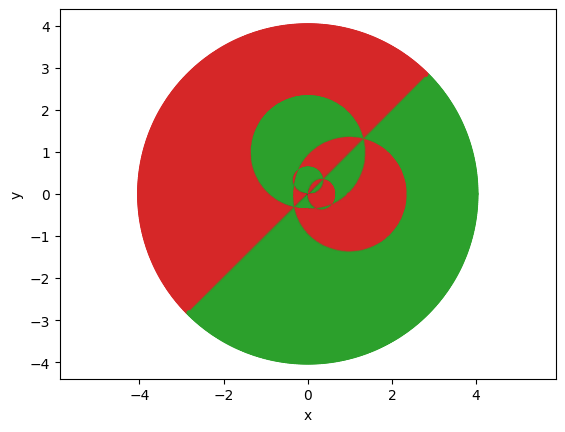

In [126]:
# visualization
plot_2d(x_2d, n)

## 2D Projection of 5D RPs (Wang et al., 2019)

In [120]:
# define radii of spheres according to (Wang et al., 2019)
r_1 = 4  # not given in (Wang et al., 2019) --> the value is estimated
r_2 = 2
r_3 = 1
r_4 = 0.5
# create samples in 2D area
x_2d = create_2d_points_inside_circle(R=r_1,steps=500)
# compute corresponding points in higher dimensions (inverse stereographic projection)
x_3d = r_2 * inv_stereo_projection(x_2d)
x_4d = r_3 * inv_stereo_projection(x_3d)
x_5d = r_4 * inv_stereo_projection(x_4d)

In [121]:
# fundemantel root system of 5-cube (Penteract)
v_k_penteract = np.array([[1,-1,0,0,0],
                        [0,1,-1,0,0],
                        [0,0,1,-1,0],
                        [0,0,0,1,-1],
                        [0,0,0,1,1]])

# perform fundamental region algorithm for projected points in 5d
n = np.zeros([x_2d.shape[1]])
for ind, val in enumerate(n):
    _,n[ind] = fundamental_region_algorithm(x_5d[:,ind], v_k_penteract)

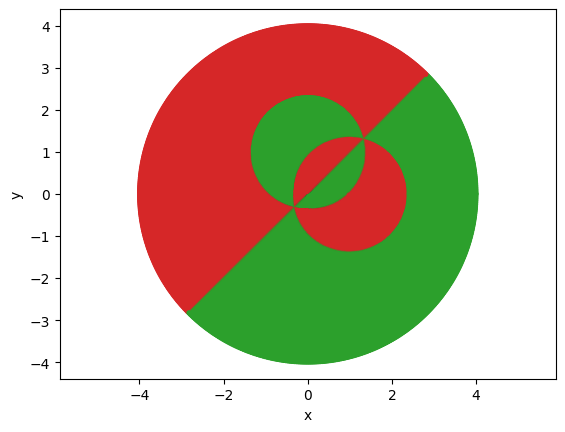

In [122]:
# visualization
plot_2d(x_2d, n)